# DESC fringes on ExitScreen

In [1]:
import h5py;
from matplotlib import pyplot as plt
import numpy as np

DAQ run with constant delay at time zero 

In [2]:
runNumber = 28495

dataDir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdfFilename = 'FLASH1_USER1-run'+str(runNumber)+'.h5'
imagePath = '/asap3/flash/gpfs/bl1/2017/data/11003895/processed/notebooks/fig/'

print(dataDir+hdfFilename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28495.h5


### Read Images from h5 file 

In [3]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')
img = hdfFile['/uncategorised/FLASH1_USER1/FLASH.FEL/FBL1.CAM/EXIT_SCREEN/dset'].value
print(type(img),'|',img.shape)

<class 'numpy.ndarray'> | (6000, 1280, 960)


/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


###  Plot Single Image  & Crop to ROI

fig/fringe_image_1009
(500, 600)


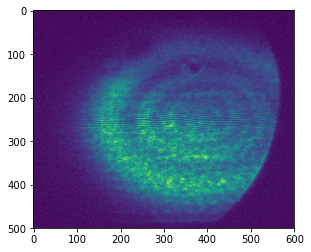

In [4]:
imgNummer = 1009

ROI_x1 = 200
ROI_x2 = 700
ROI_y1 = 100
ROI_y2 = 700

for index in range(imgNummer,imgNummer+1):
    imgName = 'fig/fringe_image_{:04d}'.format(index)
    singleImg = img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]
    print(imgName)
    plt.clf()
    plt.imshow(singleImg)
#     plt.imsave(imgName,singleImg)

print(singleImg.shape)

## Single Image

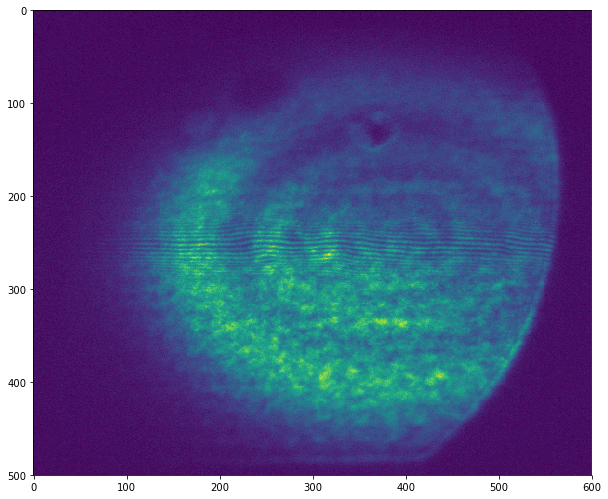

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(singleImg);

## DAQ drop rate
### Integrate cropped Image

In [6]:
integral = np.asarray([np.sum(img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]) for index in range(0,img.shape[0])])   
logicMap = (integral>25000)

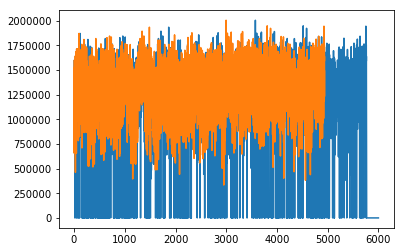

In [7]:
plt.plot(integral)
plt.plot(integral[logicMap]);

In [8]:
res = [i for i, val in enumerate(logicMap) if val]
print('Number of blanks in the end:', len(logicMap)-res[-1])
print('Acutal Rate in dataset (without appended blanks): % .3f '%(len(res)/res[-1]))

Number of blanks in the end: 236
Acutal Rate in dataset (without appended blanks):  0.857 


## Cut blanks from dataset & Crop all images to ROI

In [9]:
print('Before:',img.shape)
img = img[logicMap][:,ROI_x1:ROI_x2,ROI_y1:ROI_y2]
print('After:',img.shape)

Before: (6000, 1280, 960)
After: (4938, 500, 600)


## Average Image

In [10]:
averageImg = np.mean(img, axis = 0)
averageImg.shape

(500, 600)

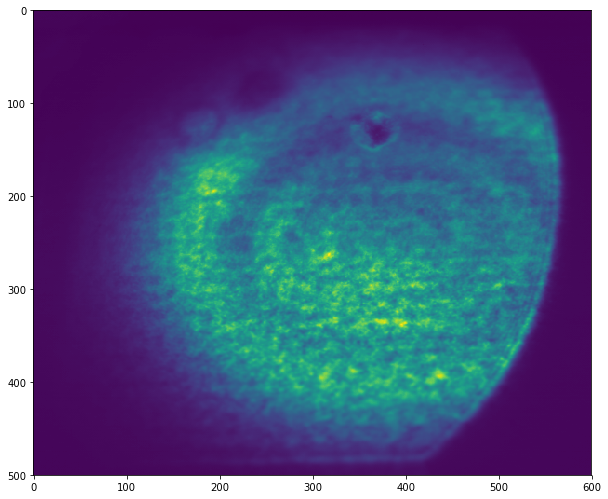

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(averageImg);

### Single Image - Average Image

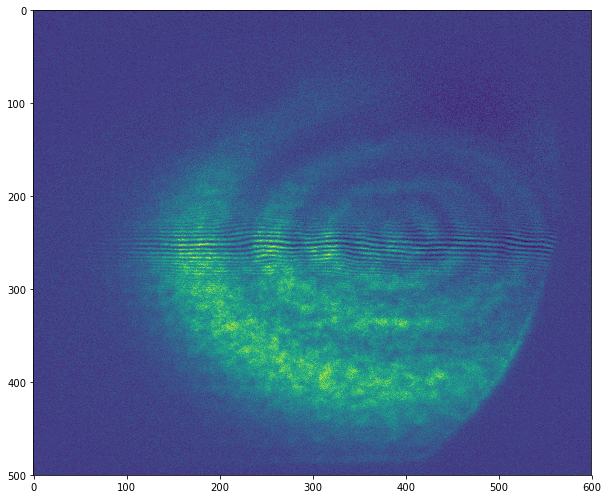

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(singleImg-averageImg);

## Standard Deviation

In [13]:
stdImg = np.std(img, axis = 0)
print(stdImg.shape)

(500, 600)


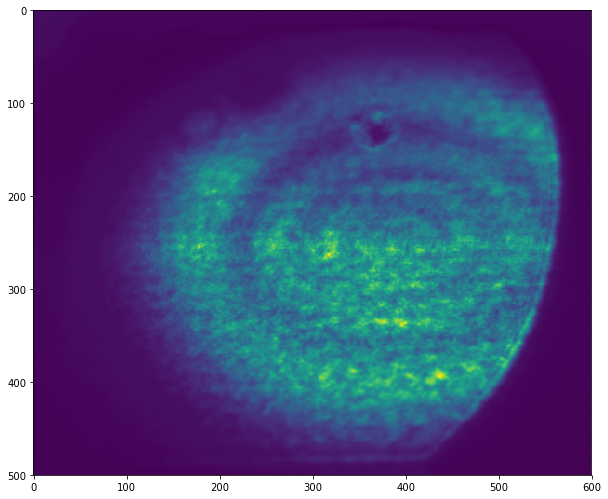

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(stdImg);

## "Background Image"  
$$ \text{BG}(I) = \frac{\text{SD}(I)}{\text{mean}(I)} $$
Suggestion for a background correction from Masoud Mehrjoo

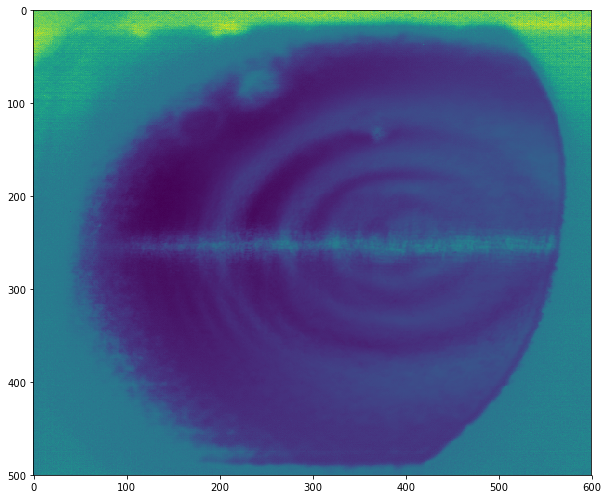

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(stdImg/averageImg);

## Single - "Background Image"

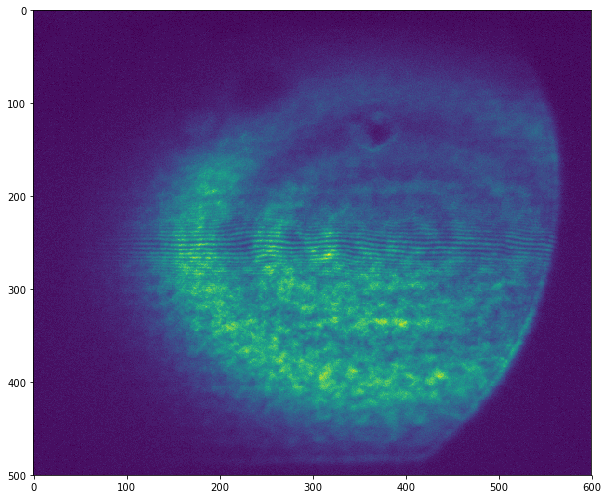

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(singleImg-(stdImg/averageImg));

***

# Assumption

 ### It seems that (single Image - averaged Image) is the most reasonable choice. 

***

### Plot with ROI & Min/Max in ROI

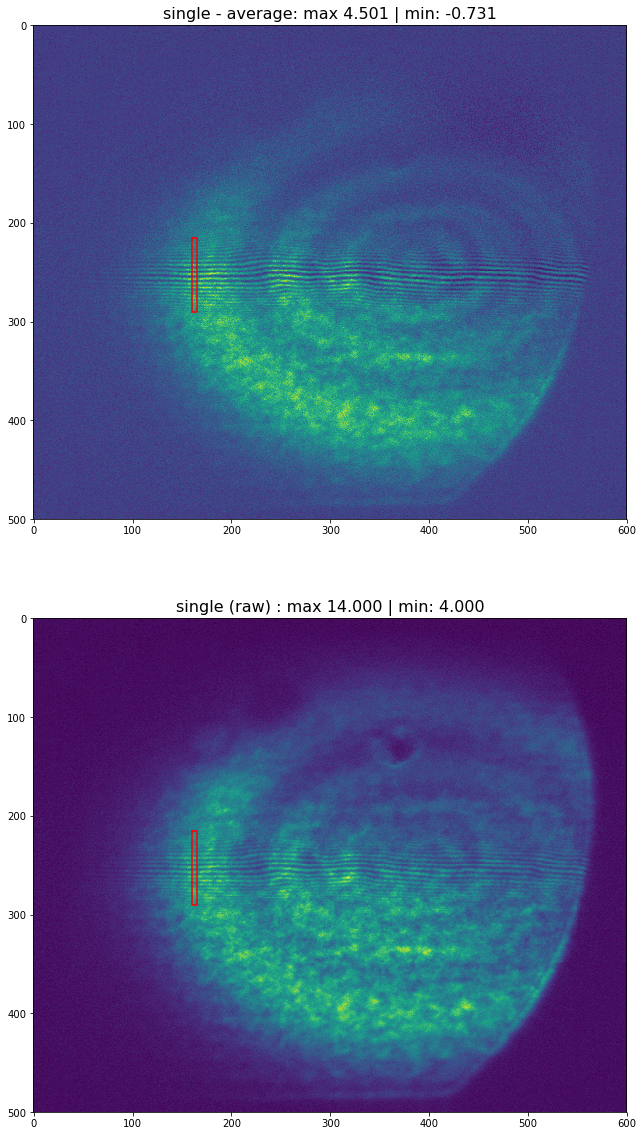

In [18]:
fringeRoiX1, fringeRoiY1 = 160, 215 
fringeRoiX2, fringeRoiY2 =  165, 290

xPlotRoi = [fringeRoiX1, fringeRoiX2, fringeRoiX2, fringeRoiX1, fringeRoiX1]
yPlotRoi = [fringeRoiY1, fringeRoiY1, fringeRoiY2, fringeRoiY2, fringeRoiY1]

shownImg = singleImg-averageImg

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(shownImg)
plt.plot(xPlotRoi,yPlotRoi,'r-')
plt.title('single - average: max %0.3f | min: %0.3f'%(np.max(shownImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2]),np.min(shownImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])), fontsize=16)
plt.subplot(212)
plt.imshow(singleImg)
plt.plot(xPlotRoi,yPlotRoi,'r-')
plt.title('single (raw) : max %0.3f | min: %0.3f'%(np.max(singleImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2]),np.min(singleImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])), fontsize=16);



### "Contrast" of ROI of all shots (raw Images)
$$contrast = \frac{Top - Valley}{Top+Valley} $$
Contrast definition from Masoud Mehrjoo
$$delta = Top - Valley $$
Delta definition has no physical meaning

In [19]:
def calcContrast(img,imageIndex):
    maxs = np.max(img[imageIndex][fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    mins = np.min(img[imageIndex][fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    return (maxs-mins)/(maxs+mins)

def calcDelta(img,imageIndex):
    maxs = np.max(img[imageIndex][fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    mins = np.min(img[imageIndex][fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    return maxs-mins

contrast = np.asarray([calcContrast(img, index) for index in range(0,img.shape[0])])
delta =  np.asarray([calcDelta(img, index) for index in range(0,img.shape[0])])

print('   Contrast |   Delta')
print('-----------------------') 
print('Max:  %.3f | %.3f' %(np.max(contrast),np.max(delta)))
print('Min:  %.3f | %.3f' %(np.min(contrast),np.min(delta)))
print('Mean: %.3f | %.3f' %(np.mean(contrast),np.mean(delta)))
print('SD:   %.3f | %.3f' %(np.std(contrast),np.std(delta)))

   Contrast |   Delta
-----------------------
Max:  1.000 | 16.000
Min:  0.333 | 3.000
Mean: 0.571 | 8.373
SD:   0.068 | 2.048


### "Contrast" of ROI of all corrected shots (single Images - averaged Image)

Contrast definition is meaningless with negative pixel values (background substraction)!

Is a transformation possible which keeps ration constant? 

In [20]:
def calcContrastCorr(img,averageImg,imageIndex):
    corrImg = img[imageIndex] - averageImg
    maxs = np.max(corrImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    mins = np.min(corrImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    return (maxs-mins)/(maxs+mins)

def calcDeltaCorr(img, averageImg,imageIndex):
    corrImg = img[imageIndex] - averageImg
    maxs = np.max(corrImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    mins = np.min(corrImg[fringeRoiX1:fringeRoiX2,fringeRoiY1:fringeRoiY2])
    return maxs-mins

contrastCorr = np.asarray([calcContrastCorr(img, averageImg, index) for index in range(0,img.shape[0])])
deltaCorr =  np.asarray([calcDeltaCorr(img, averageImg, index) for index in range(0,img.shape[0])])

print('       Contrast |   Delta')
print('-------------___----------') 
print('Max:  %.3f | %.3f' %(np.max(contrastCorr),np.max(deltaCorr)))
print('Min:  %.3f | %.3f' %(np.min(contrastCorr),np.min(deltaCorr)))
print('Mean:     %.3f | %.3f' %(np.mean(contrastCorr),np.mean(deltaCorr)))
print('SD:     %.3f | %.3f' %(np.std(contrastCorr),np.std(deltaCorr)))

       Contrast |   Delta
-----------------------
Max:  3169.500 | 10.833
Min:  -23479.000 | 2.970
Mean:     -6.958 | 4.877
SD:     451.546 | 0.992
